## Regression Modelling

The objective of this notebook is to train models using the most effective methods noted in the literature. We are aiming to train models comparable to the winning teams of a 2017 DREAM challenge by evaluating our models by the same standard. We are training models for population perception which was the second subchallenge, the first being individual prediction.

To train our models to predict population perception we will aggregate the mean of the responses accross all subjects. This will reduce our observations by a factor of the number of subjects. Our observations will go from ~49,000 to ~1,000.



## Import Statments

In [1]:
# Math/Data Libraries
import scipy
import numpy as np
import pandas as pd

# Visalisation
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

# I/O
import json
import xlrd

# Jupyter/IPython Utility
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Paths

In [2]:
path_to_transformed_data = "../../../data/transformed/"
path_to_data = "../../../data/"

## Import Data
---


In [3]:
%%time
raw = pd.read_pickle(path_to_transformed_data + "raw_training_set.zip")

CPU times: user 5.6 s, sys: 5.77 s, total: 11.4 s
Wall time: 14.7 s


In [4]:
%%time
mean = pd.read_pickle(path_to_transformed_data + 'mean_training_set.zip')

CPU times: user 137 ms, sys: 68.7 ms, total: 206 ms
Wall time: 256 ms


In [5]:
raw.head() # 200,000,000 data points about subjects, molecules and the responses between them
print('(Full Observations)\nTotal Rows: '+ raw.shape[0].__str__()
      + '\nTotal Columns: '+ raw.shape[1].__str__())

,CID,Odor,Odor dilution,SUBJECT,Gender,Race,Ethnicity,Age,SMELL?,SMELLKNOWN?,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,16741,2-Phenylethyl isothiocyanate,1,1.0,M,Black,Non-Hispanic,45,I smell something,I don't know what the odor is,...,0,0,0,0,1,0,0,0,1,0
1,16741,2-Phenylethyl isothiocyanate,0,1.0,M,Black,Non-Hispanic,45,I smell something,I don't know what the odor is,...,0,0,0,0,1,0,0,0,1,0
2,16741,2-Phenylethyl isothiocyanate,1,2.0,M,Black,Non-Hispanic,25,I smell something,I don't know what the odor is,...,0,0,0,0,1,0,0,0,1,0
3,16741,2-Phenylethyl isothiocyanate,0,2.0,M,Black,Non-Hispanic,25,I smell something,I don't know what the odor is,...,0,0,0,0,1,0,0,0,1,0
4,16741,2-Phenylethyl isothiocyanate,1,3.0,M,Black,Non-Hispanic,48,I smell something,I don't know what the odor is,...,0,0,0,0,1,0,0,0,1,0


(Full Observations)
Total Rows: 41650
Total Columns: 4903


In [6]:
mean.head() # 4,000,000 data points relating population responses to molecular features 
print('(Mean Observations)\nTotal Rows: '+ mean.shape[0].__str__()
      + '\nTotal Columns: '+ mean.shape[1].__str__())

,CID,Odor dilution,INTENSITY,PLEASANTNESS,FAMILIARITY,EDIBLE,BAKERY,SWEET,FRUIT,FISH,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,1001,0,25.961538,47.807692,38.692308,22.666667,50.000000,8.666667,0.000000,35.000000,...,0,0,0,0,0,0,0,0,0,0
1,1001,1,65.404255,28.425532,47.191489,28.000000,2.000000,13.000000,33.000000,30.526316,...,0,0,0,0,0,0,0,0,0,0
2,101010,0,21.761905,48.666667,24.476190,59.000000,0.000000,13.500000,1.000000,6.000000,...,0,0,0,0,0,0,0,0,1,0
3,101010,1,67.630435,39.760870,53.043478,33.000000,9.400000,21.400000,28.642857,18.666667,...,0,0,0,0,0,0,0,0,1,0
4,101604,0,40.650000,66.125000,55.000000,34.705882,20.166667,43.967742,33.315789,0.000000,...,0,0,1,0,1,0,1,0,1,0


(Mean Observations)
Total Rows: 810
Total Columns: 4894


## Raw vs Mean values
---
Our raw values take much longer for training and produce worse results overall for population prediction. For our purposes we will use the mean values of population perception as tragets - reducing training times and increasing performnace. Both of which are desirable. It should be noted that this was the approach taken by the winning team for population prediction.

## Selecting our X and Y - using mean responses

In [7]:
X = mean.iloc[:, 25:]
X['Odor dilution'] = mean['Odor dilution']

In [8]:
Y = mean.iloc[:, 2:25]
Y.drop(['FAMILIARITY'], axis=1, inplace=True)


## Missing Data - X. (our molecular descriptors)

In [9]:
# We have missing values in both datasets
# Simplest method is to drop the 1160 columns that contain NaN
X.isna().any().value_counts()

False    3710
True     1160
dtype: int64

In [10]:
# Simple first. Drop columns containing any NaN
X.dropna(how='any', axis=1, inplace=True)

X.isna().any().value_counts()

False    3710
dtype: int64

## Modelling
---


### Different Machine Learning Algorithms

Here I am going to try out a plethora of applicable machine learning algorithms using default parameters and standard scaling accross all moleculer descriptors(X) for the only preprocessing. These serve as a baseline for different model performance before tuning inputs or Hyperparameters.

The following regression algorithms (all of which use sklearn implmentations) are tested:

#### Linear Models

- Ordinary Least Squares (OLS)
- Ridge Regression  
- Lasso Regression
- Elasticnet Search
- Bayesian Ridge Regression

#### Ensemble Methods

- Random Forest
- ExtraTrees Random Forest
- AdaBoost
- Gradient Tree Boosting (GBT)

#### Other

- SVM
- Neural Network



## Multi Model Regression
---


## Importing estimators and transformers

In [11]:
# from sklearn import feature_selection ### use 3708 for now 
# SelectFromModel(LinearSVC(penalty="l1")) ### use to select features as poert of pipeline

# Pre-processing
from sklearn.preprocessing import StandardScaler

# Algorithms - Estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor

# scikit learn utilities
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, cross_val_predict

## Base Learners

In [12]:
# Assemble Pipelines for base learners

linear_ols = make_pipeline(StandardScaler(), LinearRegression())
linear_ridge = make_pipeline(StandardScaler(), Ridge())
linear_lasso = make_pipeline(StandardScaler(), Lasso())
linear_elastic = make_pipeline(StandardScaler(), ElasticNet())
bayesian_ridge_regression = make_pipeline(StandardScaler(), BayesianRidge())

random_forest = make_pipeline(StandardScaler(), RandomForestRegressor())
extra_trees = make_pipeline(StandardScaler(), ExtraTreesRegressor())
ada_boost = make_pipeline(StandardScaler(), AdaBoostRegressor())
gradient_boosting = make_pipeline(StandardScaler(), GradientBoostingRegressor())

neural_net = make_pipeline(StandardScaler(), MLPRegressor())

In [13]:
BASE_LEARNER_TITLES = ['Linear (OLS)',
                       'Linear (Ridge)',
                       'Linear (Lasso)',
                       'Linear (ElasticNet)',
                       'Linear (BayesianRidge)',
                       'Random Forest',
                       'ET Random Forest',
                       'AdaBoost',
                       'Gradient Boosting',
                       'Neural Net',
                      ]

TARGET_COLUMN_TITLES = list(Y.columns)

In [14]:
# create dataframe for prediction results
cross_val_predictions = pd.DataFrame(data=Y.values,
                                    columns=[t + ' (ACTUAL)' for t in TARGET_COLUMN_TITLES])

## Training Base Models - making cross validation predictions

In [15]:
%%time
# 5-Fold Cross validation - for each target in Y
for target in TARGET_COLUMN_TITLES:
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[0]) +')'] = cross_val_predict(linear_ols, X, Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[1]) +')'] = cross_val_predict(linear_ridge, X, Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[2]) +')'] = cross_val_predict(linear_lasso, X, Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[3]) +')'] = cross_val_predict(linear_elastic, X, Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[4]) +')'] = cross_val_predict(bayesian_ridge_regression, X, Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[5]) +')'] = cross_val_predict(random_forest, X, Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[6]) +')'] = cross_val_predict(extra_trees, X, Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[7]) +')'] = cross_val_predict(ada_boost, X, Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[8]) +')'] = cross_val_predict(gradient_boosting, X, Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[9]) +')'] = cross_val_predict(neural_net, X, Y[target], cv=5)



/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


CPU times: user 1h 20min 29s, sys: 5min 14s, total: 1h 25min 44s
Wall time: 1h 4min 4s


# Viewing predictions
---

### Intensity Predictions

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - INTENSITY')

INTENSITY (Linear (OLS))             -0.002796
INTENSITY (Linear (Ridge))            0.329194
INTENSITY (Linear (Lasso))            0.607200
INTENSITY (Linear (ElasticNet))       0.562750
INTENSITY (Linear (BayesianRidge))    0.508144
INTENSITY (Random Forest)             0.633285
INTENSITY (ET Random Forest)          0.574587
INTENSITY (AdaBoost)                  0.612032
INTENSITY (Gradient Boosting)         0.603330
INTENSITY (Neural Net)                0.411572
Name: actual, dtype: float64

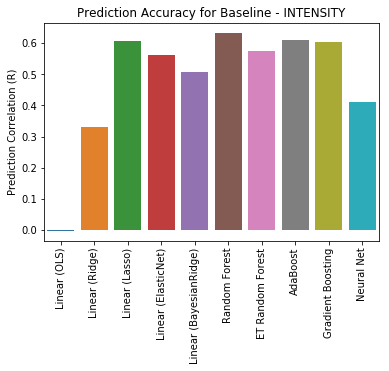

In [16]:
int_predictions = cross_val_predictions.iloc[:, 22:32]
int_predictions['actual'] = cross_val_predictions.iloc[:, 0]
int_predictions_corr = int_predictions.corr()['actual'][:-1]
sb.barplot(x=BASE_LEARNER_TITLES, y=int_predictions_corr.values).set_ylabel('Prediction Correlation (R)')
plt.xticks(rotation=90)
plt.title('Prediction Accuracy for Baseline - INTENSITY')
int_predictions_corr

## Pleasantness Predictions

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - PLEASANTNESS')

PLEASANTNESS (Linear (OLS))             -0.016942
PLEASANTNESS (Linear (Ridge))            0.274511
PLEASANTNESS (Linear (Lasso))            0.446368
PLEASANTNESS (Linear (ElasticNet))       0.500917
PLEASANTNESS (Linear (BayesianRidge))    0.486192
PLEASANTNESS (Random Forest)             0.430873
PLEASANTNESS (ET Random Forest)          0.501847
PLEASANTNESS (AdaBoost)                  0.479653
PLEASANTNESS (Gradient Boosting)         0.510164
PLEASANTNESS (Neural Net)                0.461048
Name: actual, dtype: float64

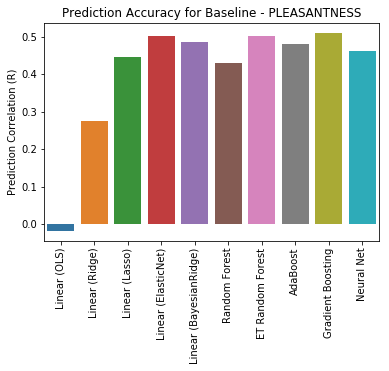

In [27]:
ple_predictions = cross_val_predictions.iloc[:, 32:42]
ple_predictions['actual'] = cross_val_predictions.iloc[:, 1]
ple_predictions_corr = ple_predictions.corr()['actual'][:-1]
sb.barplot(x=BASE_LEARNER_TITLES, y=ple_predictions_corr.values).set_ylabel('Prediction Correlation (R)')
plt.xticks(rotation=90)
plt.title('Prediction Accuracy for Baseline - PLEASANTNESS')
ple_predictions_corr

In [ ]:
sem_predictions = cross_val_predictions.iloc[:, 42:]
semantic_labels = list(TARGET_COLUMN_TITLES[2:])
for label, i in zip(semantic_labels, range(len(sem_predictions))):
    sem_predictions[label] = cross_val_predictions.iloc[:, (i+2)]


## Semantic Descriptor Predictions

In [19]:
sem_predictions_corr = pd.DataFrame()
for i in range(0, 200, 10):
    sem_predictions_corr[semantic_labels[i//10]] = sem_predictions.corr()[semantic_labels[i//10]][i:i+10].values


sem_predictions_corr['Algorithm'] = BASE_LEARNER_TITLES

sem_predictions_corr.set_index('Algorithm', inplace=True)

In [20]:
sem_predictions_corr

,EDIBLE,BAKERY,SWEET,FRUIT,FISH,GARLIC,SPICES,COLD,SOUR,BURNT,ACID,WARM,MUSKY,SWEATY,URINOUS,DECAYED,WOOD,GRASS,FLOWER,CHEMICAL
Algorithm,,,,,,,,,,,,,,,,,,,,
Linear (OLS),0.051948,-0.016376,-0.048329,-0.047520,-0.000436,0.049248,0.040033,-0.032546,0.041988,0.013571,-0.016764,-0.010949,-0.021148,0.044024,-0.022829,0.065382,0.030165,0.009855,-0.002843,0.032127
Linear (Ridge),-0.038422,0.062396,0.032743,0.081109,-0.000415,0.094981,-0.047089,-0.024787,0.031211,0.048519,0.028618,-0.049591,0.084676,0.003043,0.103296,-0.017346,0.104068,-0.020926,0.006144,0.055291
Linear (Lasso),0.046036,0.053701,0.208832,0.260916,0.152292,0.203160,-0.058596,0.024495,0.095672,0.114655,0.222317,0.153047,0.197894,0.218665,0.160119,-0.000551,0.057007,-0.042538,0.118186,0.246421
Linear (ElasticNet),-0.005730,0.086825,0.228191,0.291745,0.188363,0.201160,-0.026190,0.047481,0.102638,0.139888,0.192076,0.166977,0.190854,0.269753,0.202127,0.018052,0.118012,-0.044900,0.108601,0.224268
Linear (BayesianRidge),0.038218,0.078405,0.220104,0.295865,0.216736,0.139566,-0.107135,-0.080193,0.143368,0.087477,-0.079837,0.017346,0.193046,0.239736,0.185215,0.011941,-0.025767,-0.091116,0.109259,0.180715
Random Forest,-0.048715,0.088739,0.151777,0.205354,0.179899,0.164218,0.051149,-0.063100,0.069035,0.107618,0.125250,0.035396,0.092394,0.168758,0.126268,0.026289,0.017696,-0.039759,0.074860,0.143506
ET Random Forest,-0.004433,0.070967,0.188325,0.235599,0.160667,0.206816,0.016025,-0.046262,0.079097,0.145795,0.132607,0.040959,0.070655,0.086055,0.101843,0.034648,0.091174,-0.006278,0.061041,0.124170
AdaBoost,0.013030,0.109030,0.053553,0.172563,0.122930,0.208953,0.041628,-0.027925,0.098298,0.089344,0.146272,0.045939,0.111622,0.154337,0.121220,0.002839,0.115209,-0.014192,0.033353,0.117681
Gradient Boosting,-0.036003,0.106797,0.154709,0.241712,0.214330,0.244016,0.034348,-0.015956,0.096603,0.131146,0.153370,0.110178,0.157436,0.163782,0.160989,0.022940,0.150270,-0.058156,0.089839,0.129510


In [38]:
# Best correlation (predicted vs actual) accross models for each semantic target
top_9_sem_targets = sem_predictions_corr.max().sort_values(ascending=False).head(9)
top_9_sem_targets

FRUIT       0.295865
SWEATY      0.269753
CHEMICAL    0.246421
GARLIC      0.244016
SWEET       0.228191
ACID        0.222317
FISH        0.216736
URINOUS     0.202127
MUSKY       0.197894
dtype: float64

In [33]:
# Top performing model for each semantic target
sem_predictions_corr.idxmax()
sem_predictions_corr.max()

EDIBLE                Linear (OLS)
BAKERY                    AdaBoost
SWEET          Linear (ElasticNet)
FRUIT       Linear (BayesianRidge)
FISH        Linear (BayesianRidge)
GARLIC           Gradient Boosting
SPICES               Random Forest
COLD           Linear (ElasticNet)
SOUR        Linear (BayesianRidge)
BURNT             ET Random Forest
ACID                Linear (Lasso)
WARM           Linear (ElasticNet)
MUSKY               Linear (Lasso)
SWEATY         Linear (ElasticNet)
URINOUS        Linear (ElasticNet)
DECAYED               Linear (OLS)
WOOD                    Neural Net
GRASS                 Linear (OLS)
FLOWER              Linear (Lasso)
CHEMICAL            Linear (Lasso)
dtype: object

EDIBLE      0.051948
BAKERY      0.109030
SWEET       0.228191
FRUIT       0.295865
FISH        0.216736
GARLIC      0.244016
SPICES      0.051149
COLD        0.047481
SOUR        0.143368
BURNT       0.145795
ACID        0.222317
WARM        0.166977
MUSKY       0.197894
SWEATY      0.269753
URINOUS     0.202127
DECAYED     0.065382
WOOD        0.152117
GRASS       0.009855
FLOWER      0.118186
CHEMICAL    0.246421
dtype: float64

### Average Performance accross all semantic descriptors

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - Average of Semantic Descriptors')

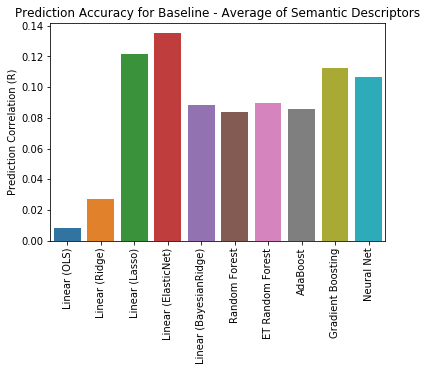

In [23]:
sb.barplot(x=BASE_LEARNER_TITLES, y=sem_predictions_corr.mean(axis=1).values).set_ylabel('Prediction Correlation (R)')
plt.xticks(rotation=90)
plt.title('Prediction Accuracy for Baseline - Average of Semantic Descriptors')

### Prediction accuracy for each target

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - EDIBLE')

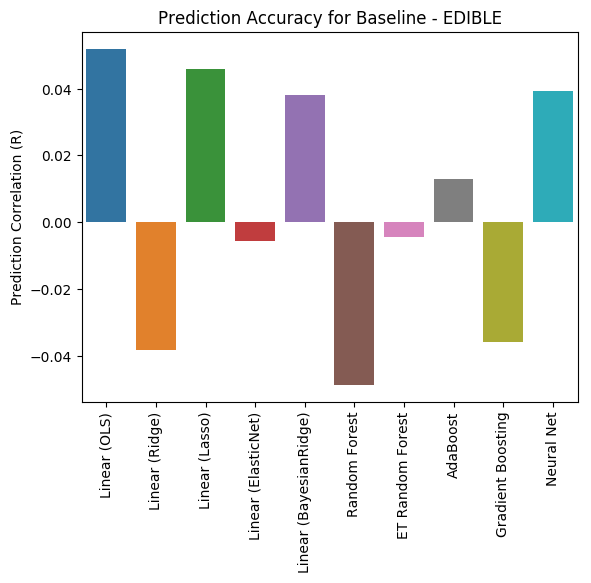

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - BAKERY')

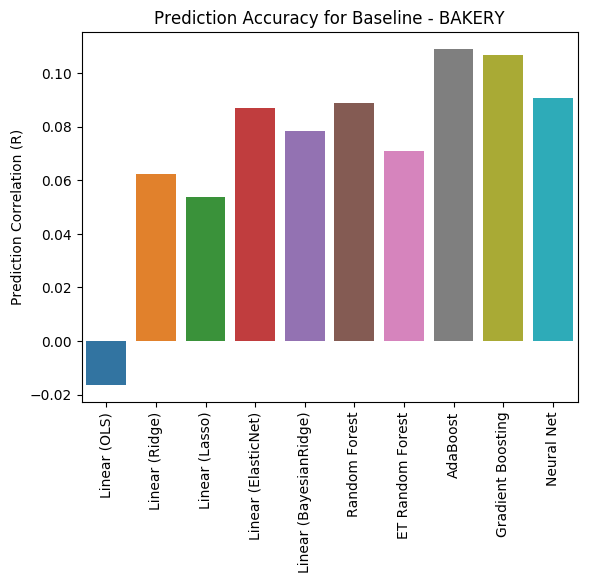

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - SWEET')

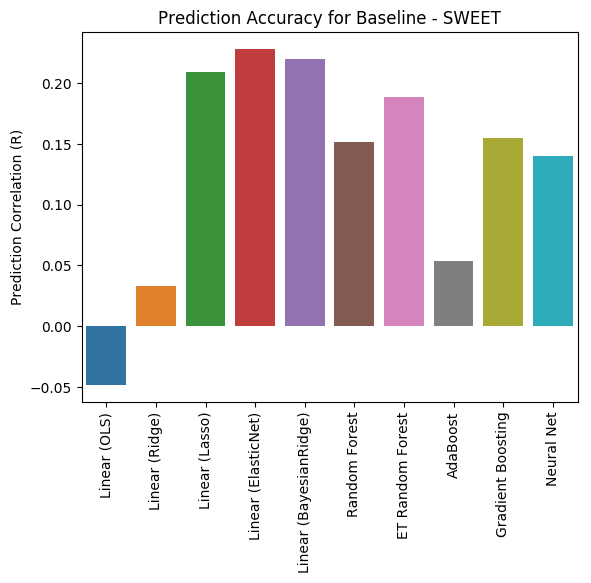

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - FRUIT')

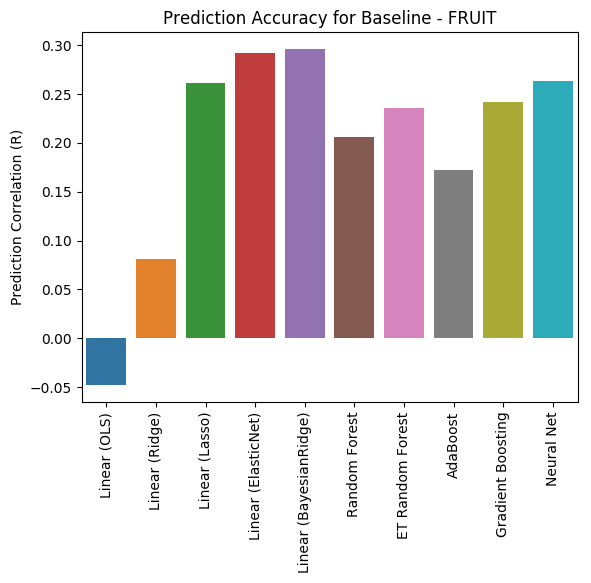

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - FISH')

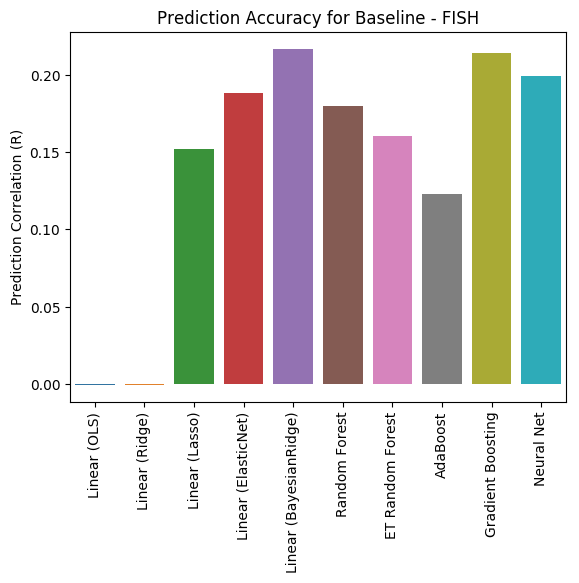

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - GARLIC')

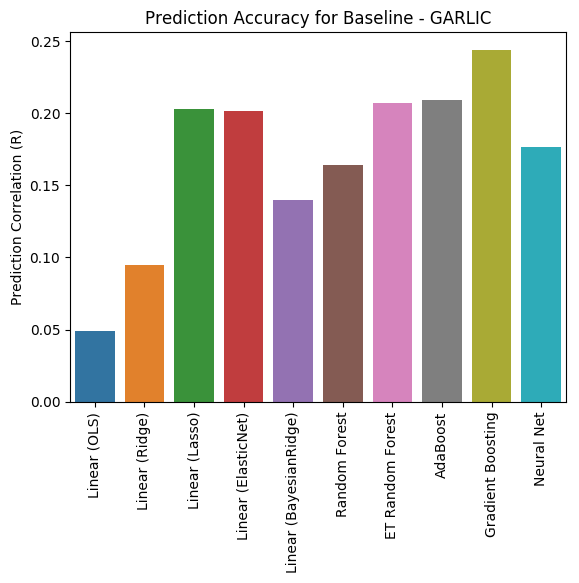

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - SPICES')

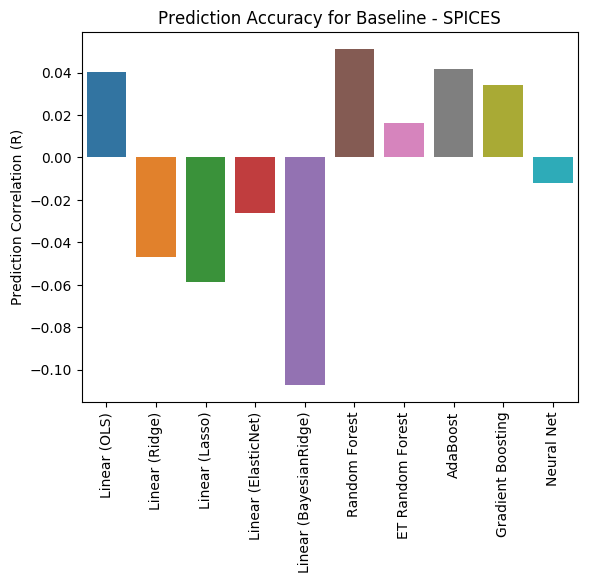

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - COLD')

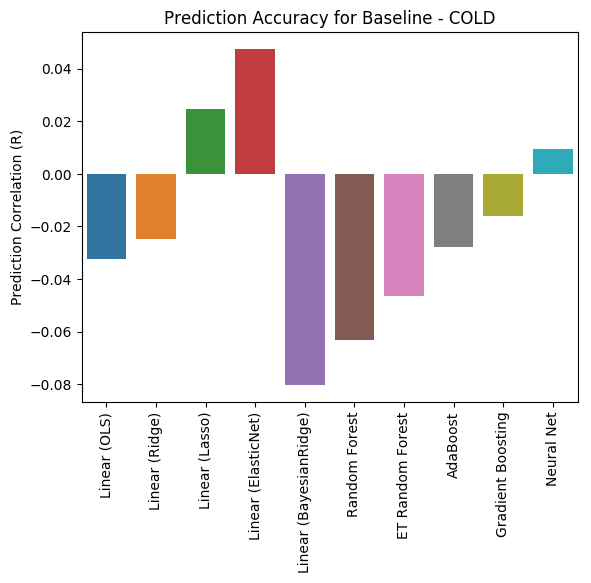

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - SOUR')

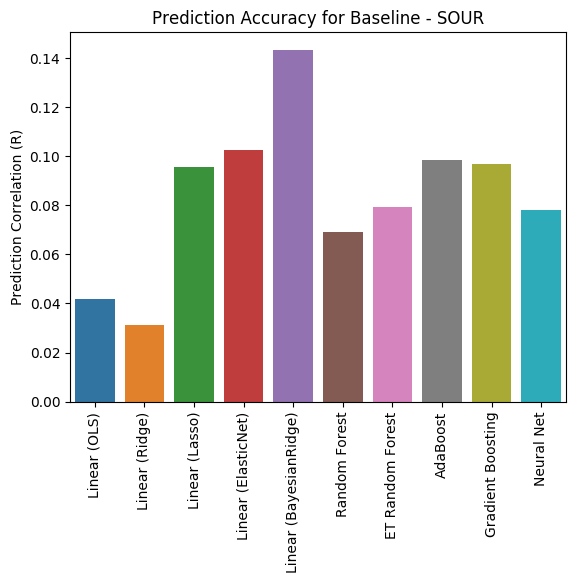

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - BURNT')

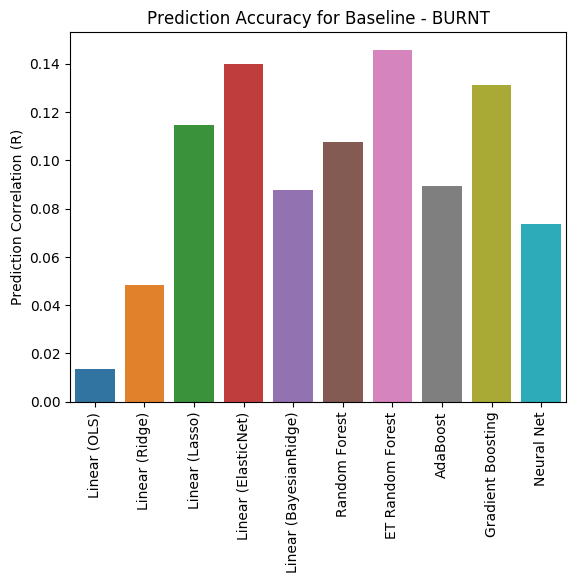

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - ACID')

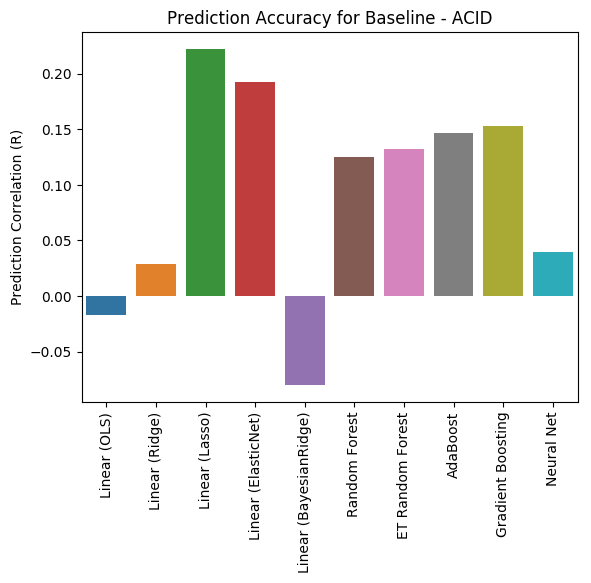

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - WARM')

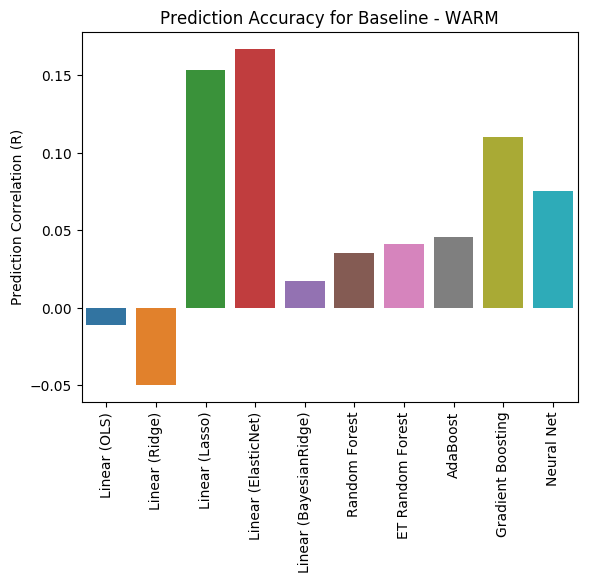

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - MUSKY')

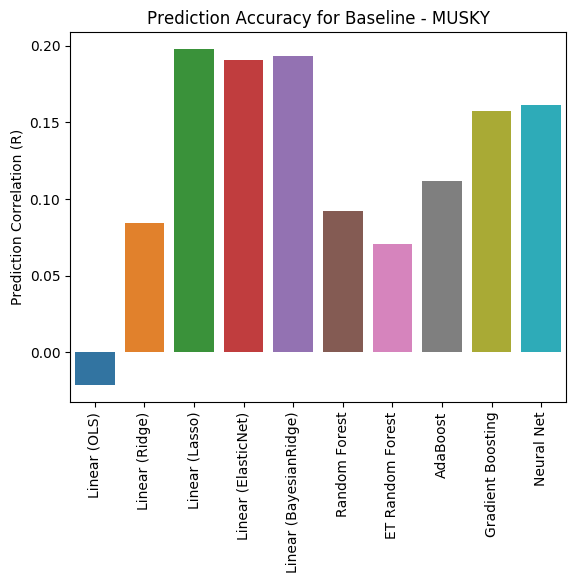

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - SWEATY')

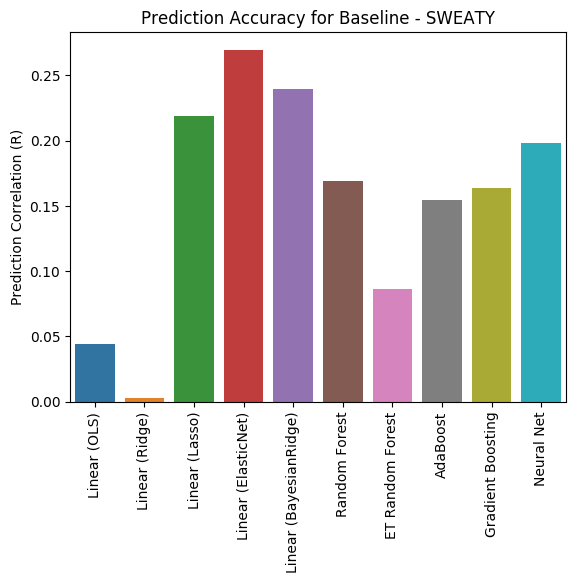

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - URINOUS')

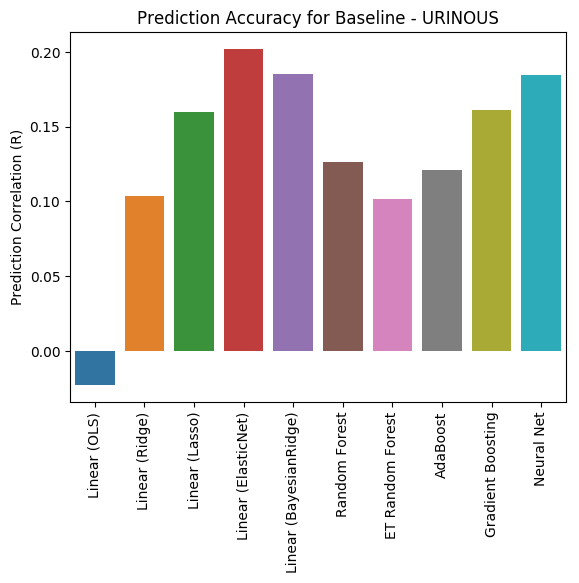

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - DECAYED')

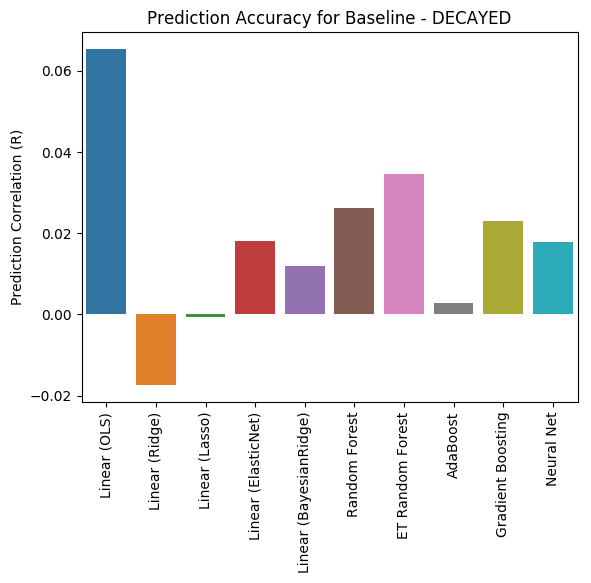

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - WOOD')

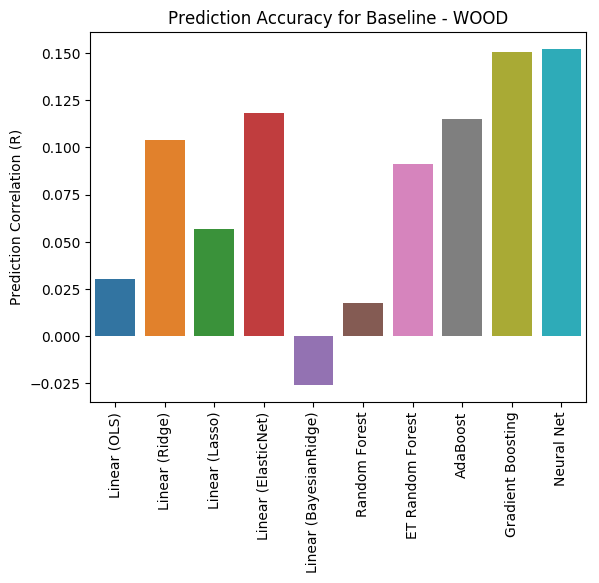

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - GRASS')

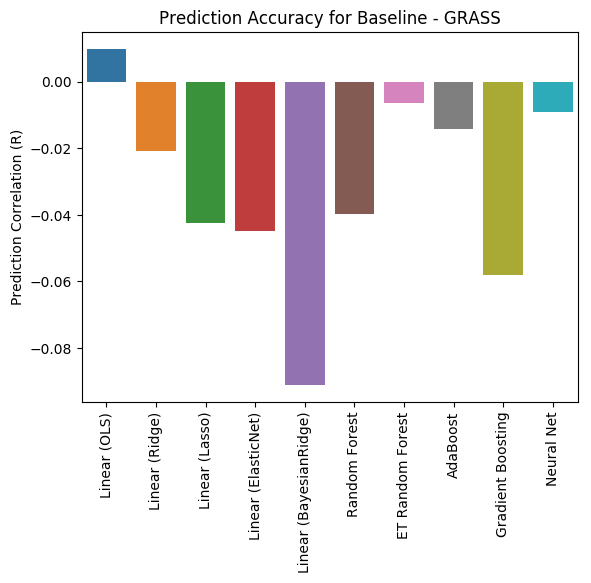

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - FLOWER')

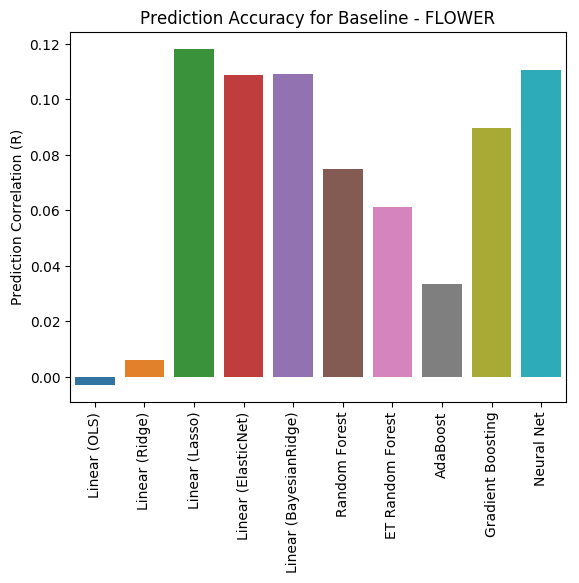

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - CHEMICAL')

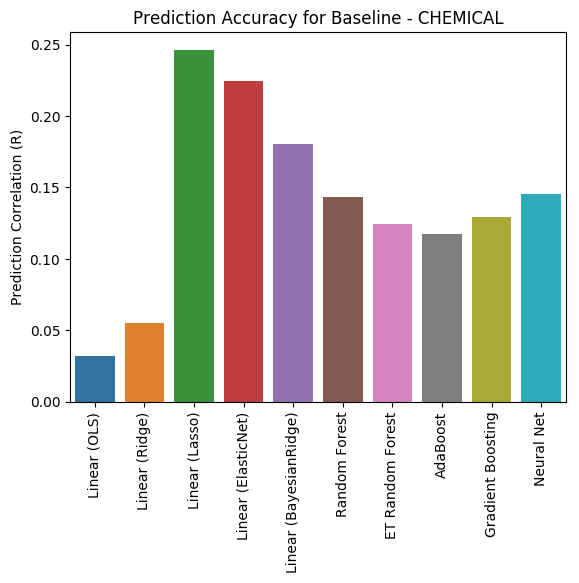

In [40]:
for target in semantic_labels:
    sb.barplot(x=BASE_LEARNER_TITLES, y=sem_predictions_corr[target]).set_ylabel('Prediction Correlation (R)')
    plt.xticks(rotation=90)
    plt.title('Prediction Accuracy for Baseline - '+ target)
    plt.show()